## This notebook is for creating code that will:
+ open a lidar file
+ create dem
+ create canopy height model
+ highlight trees above a certain height

In [1]:
# You need to run this cell to get things setup
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot

import geopandas
import matplotlib.pyplot as plt        # the basic python plotting library

In [2]:
import os                              # a base python package for doing basic operations
import sys                             # a base python package for doing system-related operations
import numpy as np                     # numpy is a numeric python library 
import rasterio as rio                 # a raster operation package - good for remote sensing data!
import pandas as pd                    # a data analysis library
import geopandas as gpd                # spatial data analysis (built on top of pandas)
import seaborn as sns                  # another graphing package - nicer graphs
import sklearn                         # a machine learning package


from pandas.plotting import scatter_matrix


In [3]:
import subprocess, glob
from osgeo import gdal

### Step 1: Open DEM File

In [4]:
# specify the folder and the file
#work_folder = r'C:\Users\ea-nz\OneDrive - Environmental Analytics\VUW\GISC424\Labs\Lab_03\Data'
#sentinel_image_filename = 'sent_2a_image_corr_QEP_segment.dat'

work_folder = r'D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013'
image_filename1 = 'DEM_BB31_1002_2013.tif'
#join these together to get the full path
ffin1 = os.path.join(work_folder, image_filename1)

#make sure the path exists
print(os.path.exists(ffin1))

#open the file with rasterio. We read the information from this file into an "object" called "src"
dem = rio.open(ffin1)
print("dem :",dem)

True
dem : <open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1002_2013.tif' mode='r'>


In [5]:
#open all dem files
image_filename2 = 'DEM_BB31_1003_2013.tif'
#join these together to get the full path
ffin2 = os.path.join(work_folder, image_filename2)
dem = rio.open(ffin2)

In [6]:
# File and folder paths
In [6]: dirpath = r"C:\HY-DATA\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\Data\CSC_Lesson6"

In [7]: out_fp = r"C:\HY-DATA\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\Data\CSC_Lesson6\Helsinki_DEM_2x2m_Mosaic.tif"

# Make a search criteria to select the DEM files
In [8]: search_criteria = "L*.tif"

In [9]: q = os.path.join(dirpath, search_criteria)

In [10]: print(q)
    

C:\HY-DATA\HENTENKA\KOODIT\Opetus\Automating-GIS-processes\Data\CSC_Lesson6\L*.tif


In [7]:
In [1]: import rasterio

In [2]: from rasterio.merge import merge

In [3]: from rasterio.plot import show

In [4]: import glob

In [5]: import os

In [8]:
dirpath = r"D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013"

#out_fp = r"D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1002_2013.tif"

search_criteria = "D*.tif"

q = os.path.join(dirpath, search_criteria)

print(q)


D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\D*.tif


In [9]:
dem_all= glob.glob(q)

dem_all

['D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1002_2013.tif',
 'D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1003_2013.tif',
 'D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1004_2013.tif',
 'D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1005_2013.tif',
 'D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1006_2013.tif',
 'D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1102_2013.tif',
 'D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1103_2013.tif',
 'D:\\2020\\GISC425\\Untitled Folder\\lds-auckland-region-2layers-GTiff\\auckland-lidar-1m-dem-2013\\DEM_BB31_1104_201

In [10]:
dem_files_to_mosaic = []

In [12]:
for fp in dem_all:
    dem = rasterio.open(fp)
    dem_files_to_mosaic.append(dem)

dem_files_to_mosaic

[<open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1002_2013.tif' mode='r'>,
 <open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1003_2013.tif' mode='r'>,
 <open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1004_2013.tif' mode='r'>,
 <open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1005_2013.tif' mode='r'>,
 <open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1006_2013.tif' mode='r'>,
 <open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dem-2013\DEM_BB31_1102_2013.tif' mode='r'>,
 <open DatasetReader name='D:\2020\GISC425\Untitled Folder\lds-aucklan

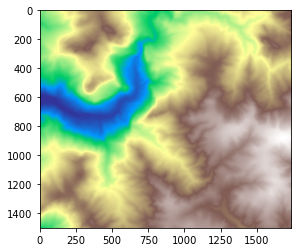

In [13]:
dem_mosaic, out_trans = merge(dem_files_to_mosaic)
show(dem_mosaic, cmap='terrain')

### Load DSM

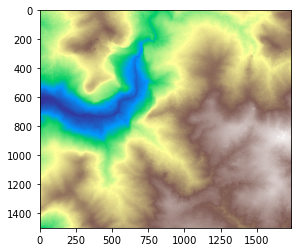

In [14]:
#path to folder
dirpath1 = r"D:\2020\GISC425\Untitled Folder\lds-auckland-region-2layers-GTiff\auckland-lidar-1m-dsm-2013"


#takes all tif files that start with D
search_criteria1 = "D*.tif"

#combining folder path and file name

z = os.path.join(dirpath1, search_criteria1)
#loading all files
dsm_all= glob.glob(z)

#combining files into a mosaic
#start with empty list
dsm_files_to_mosaic = []
#for each file in the list of files, open it and combine it with the others 
for fp1 in dsm_all:
    dsm = rasterio.open(fp1)
    dsm_files_to_mosaic.append(dsm)

# Merge function returns a single mosaic array and the transformation info
dsm_mosaic, out_trans = merge(dsm_files_to_mosaic)
#display mosaic
show(dsm_mosaic, cmap='terrain')

In [ ]:
#haven't checked CRS or looked at meta data
# Copy the metadata
#In [18]: out_meta = src.meta.copy()

# Update the metadata
#In [19]: out_meta.update({"driver": "GTiff", "height": mosaic.shape[1],"width": mosaic.shape[2],
#"transform": out_trans,"crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "}) 

### Step 2: Canopy Height

In [ ]:
show(dsm_mosaic, cmap='terrain')
show(dem_mosaic, cmap='terrain')

 canopy height models (CHM) = DSM - DEM

In [15]:
# Calculate canopy height model
chm = dsm_mosaic - dem_mosaic

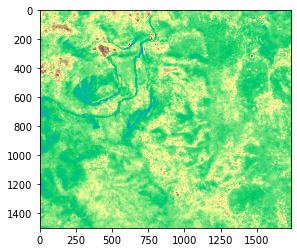

In [16]:
show(chm, cmap='terrain')